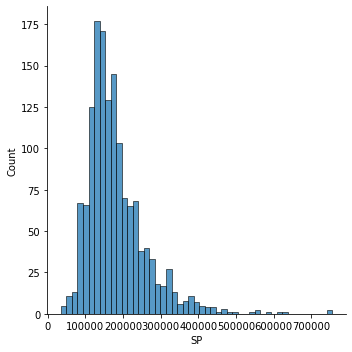

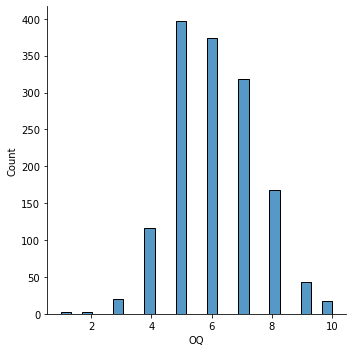

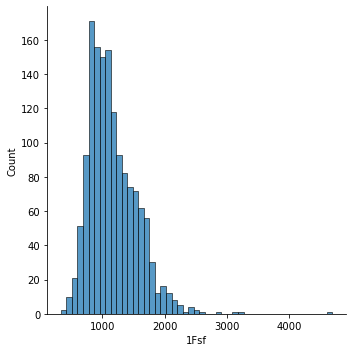

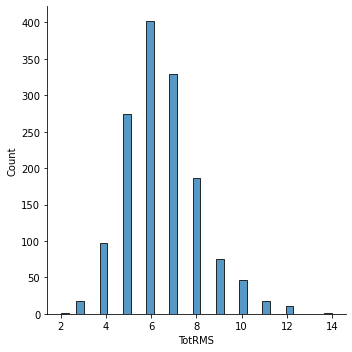

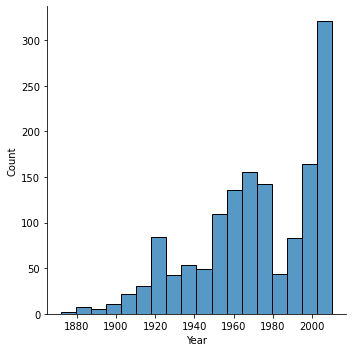

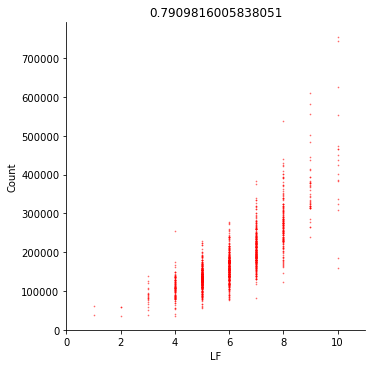

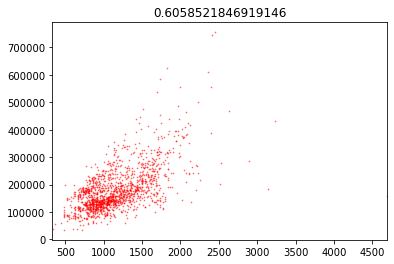

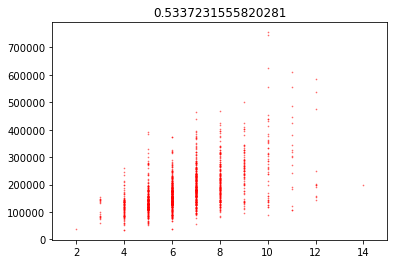

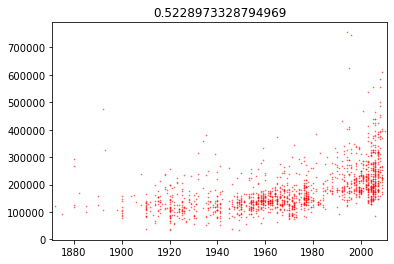

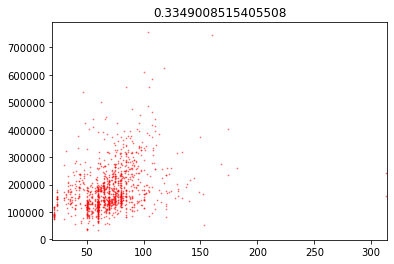

[0.56487338 0.97782255]
[484.50943214 713.84802267 520.66132819 ... 672.04739287 609.91132155
 710.45878242]


In [21]:
#%% Librería
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
#%% Accesar data
class pFinal():
    def __init__(self, dName):
        self.dName = dName
        self.coefs = {}
        #Se carga la data al crear la instancia de la clase pFinal
        fPath = os.getcwd()
        dPath = 'proyecto_data'
        data = np.load(os.path.join(fPath, dPath, self.dName))
        self.data=pd.DataFrame(data, columns=['SP','OQ','1Fsf','TotRMS','Year','LF'])        
    def getStats(self):
        average = dict(self.data.mean(axis = 0))
        maxCol = self.data.max(axis = 0)
        minCol = self.data.min(axis = 0)
        peak = dict(maxCol-minCol)
        maxCol = dict(maxCol)
        minCol = dict(minCol)
        desvEst = dict(self.data.std(axis = 0))
        self.stats = pd.DataFrame(index = ['average','maxCol','minCol','peak','desvEst'],
                     data = (average,maxCol,minCol,peak,desvEst))
    def graphHist(self):
        for i in self.data.columns:
            
            #print(self.data[i])
            hist = sns.displot(self.data[i],kind='hist')
    def r2(self):   
        yav = self.stats['SP']['average']
        ty = self.data['SP'].apply(lambda y: y - yav)
        sumvarY = self.data['SP'].apply(lambda y: (y-yav)**2).sum()
        for i in self.data.columns[1:]:
            #sumxy = (self.data['SP']:self.data[i]).sum()
            xav = self.stats[i]['average']
            num = (self.data[i].apply(lambda x: x - xav)*ty).sum()
            sumvarX = self.data[i].apply(lambda x: (x-xav)**2).sum()
            deno = np.sqrt(sumvarY*sumvarX)
            self.coefs[i] = num/deno
    def plots(self):
        #fig, axs = plt.subplots(5)
        x=0
        for i in self.data.columns[1:]:
            plt.scatter(self.data[i], self.data['SP'], s=0.5, c='r', alpha=0.5)
            plt.title(self.coefs[i])
            plt.xlim(self.stats[i]['minCol']-1, self.stats[i]['maxCol']+1)
            plt.show()
    def entrenar(self,x,y,epch=0,impErr=0,alpha=0):
        #Beta0 = betas[0] y Beta1 = betas[1]
        betas = np.random.rand(2)
        print(betas)
        x = np.array(x)
        M = np.transpose(np.array([x, np.full_like(x,1)]))
        y = np.array(y)
        yPredict = np.dot(M, betas)
        print(yPredict)
            
            
#%% Manejo de instancias
pFinal = pFinal('proyecto_training_data.npy')
stats = pFinal.getStats()
pFinal.graphHist()
pFinal.r2()
pFinal.plots()
#Se elige 1Fsf como la mejor opcion
pFinal.entrenar(pFinal.data['1Fsf'], pFinal.data['SP'])
